In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
from sklearn.metrics import confusion_matrix
from statistics import mode
from collections import Counter
import random
%matplotlib inline

In [80]:
#read file
df=pd.read_csv("iris.csv", names = ["sepal length", "sepal width", "petal length", "petal width", "name"])
df.head()

,sepal length,sepal width,petal length,petal width,name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   name          150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [98]:
#split data into training set and validation set - random so samples don't contain only one species
bitmask = np.random.rand(len(df)) < 0.7 #want training data to be around 70%
train = df[bitmask]
test = df[~bitmask]

#hashmaps for labels
all_labels = dict(enumerate(np.array(df["name"])))
train_labels = dict(enumerate(np.array(train["name"])))
test_labels = dict(enumerate(np.array(test["name"])))

#refer to various parts of df
features = ["sepal length", "sepal width", "petal length", "petal width"]
data = train.loc[:, features]
target = train["name"]

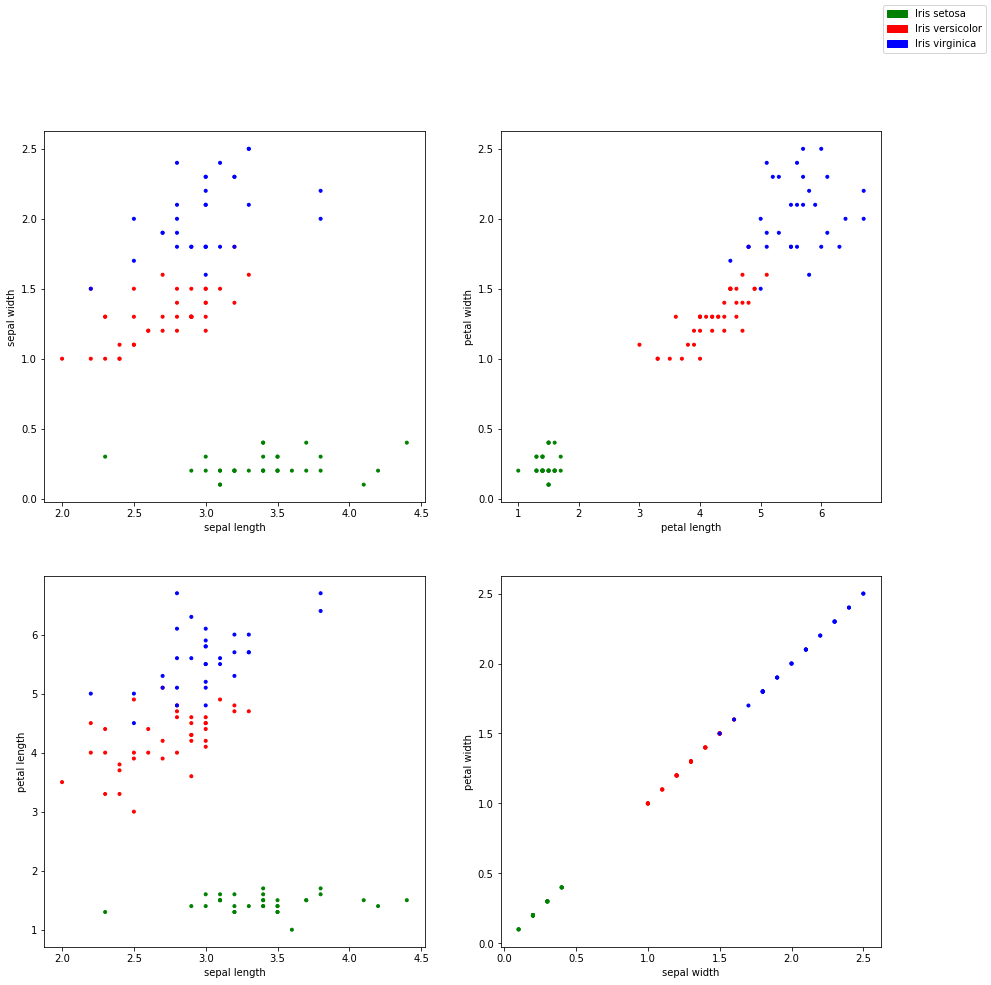

In [5]:
#exploratory data analysis
s_length, s_width, p_length, p_width = train["sepal width"], train["petal width"], train["petal length"], train["petal width"]

colors = {"Iris-setosa": "green", "Iris-versicolor": "red", "Iris-virginica": "blue"}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 15))
plt.rcParams["lines.markersize"] = 3

#make custom legend artist
green_patch, red_patch, blue_patch = mpatches.Patch(color = "green", label="Iris setosa"), mpatches.Patch(color="red", label="Iris versicolor"), mpatches.Patch(color = "blue", label="Iris virginica")
fig.legend(handles=[green_patch, red_patch, blue_patch])

ax1.scatter(s_length, s_width, c = train["name"].apply(lambda x: colors[x]))
ax1.set_xlabel("sepal length")
ax1.set_ylabel("sepal width")

ax2.scatter(p_length, p_width, c = train["name"].apply(lambda x: colors[x]))
ax2.set_xlabel("petal length")
ax2.set_ylabel("petal width")

ax3.scatter(s_length, p_length, c = train["name"].apply(lambda x: colors[x]))
ax3.set_xlabel("sepal length")
ax3.set_ylabel("petal length")

ax4.scatter(s_width, p_width, c = train["name"].apply(lambda x: colors[x]))
ax4.set_xlabel("sepal width")
ax4.set_ylabel("petal width")

plt.show()

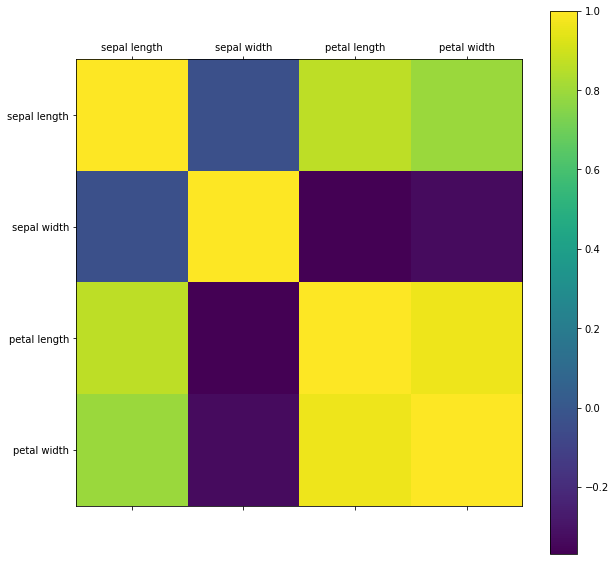

In [7]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.matshow(train.corr()) #plot correlation heat map for 4x4 combinations of variables
ax.set_xticklabels([""]+["sepal length", "sepal width", "petal length", "petal width"])
ax.set_yticklabels([""]+["sepal length", "sepal width", "petal length", "petal width"])
fig.colorbar(ax.matshow(train.corr()))
plt.show()

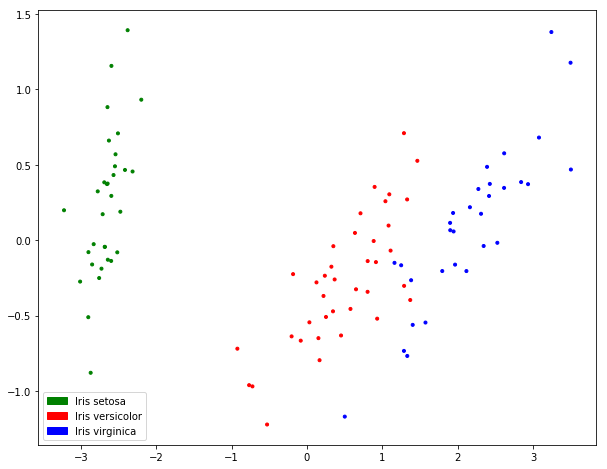

In [8]:
#use PCA to reduce dimensionality of data
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
PrincipalComponents = pca.fit_transform(data)

colors = dict(zip(["Iris-setosa", "Iris-versicolor", "Iris-virginica"], ["green", "red", "blue"]))

fig, ax = plt.subplots(figsize = (10, 8))

green_patch, red_patch, blue_patch = mpatches.Patch(color = "green", label="Iris setosa"), mpatches.Patch(color="red", label="Iris versicolor"), mpatches.Patch(color = "blue", label="Iris virginica")
ax.legend(handles=[green_patch, red_patch, blue_patch])

ax.scatter(PrincipalComponents[:, 0], PrincipalComponents[:, 1], c = train["name"].apply(lambda x: colors[x]))
plt.show()

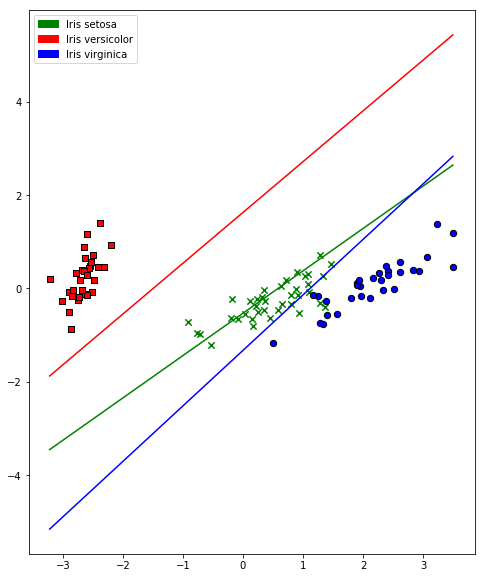

In [9]:
#use lda to find best separating hyperplanes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = 2)
separate = lda.fit(PrincipalComponents, target)

fig, ax = plt.subplots(figsize = (8, 10))

#plot data
for l,c,m in zip(np.unique(target),['r','g','b'],['s','x','o']):
    ax.scatter(PrincipalComponents[target==l,0],
                PrincipalComponents[target==l,1],
                c=c, marker=m, label=l,edgecolors='black', s=40)

x1 = np.array([np.min(PrincipalComponents[:,0], axis=0), np.max(PrincipalComponents[:,0], axis=0)])

#plot separating lines
for i, c in enumerate(['r','g','b']):
    b, w1, w2 = lda.intercept_[i], lda.coef_[i][0], lda.coef_[i][1]
    y1 = -(b+x1*w1)/w2    
    ax.plot(x1,y1,c=c)
    
green_patch, red_patch, blue_patch = mpatches.Patch(color = "green", label="Iris setosa"), mpatches.Patch(color="red", label="Iris versicolor"), mpatches.Patch(color = "blue", label="Iris virginica")
ax.legend(handles=[green_patch, red_patch, blue_patch])

plt.show()

#NOTE: there are 3 lines(1 for each class) because sklearn.lda does multiclass separation using a "one-vs-rest" approach

In [11]:
#validation of LDA model. NB: LDA assumes independent Gaussian distribution for each feature, so equivalent to Naive Bayes
red_test = pca.transform(test.loc[:, features]) #apply PCA (based on training data) to test data

pred_labels = lda.predict(red_test) #predicts class labels for red_test, returns array as output
true_labels = np.array(test["name"])

error_count = sum(np.not_equal(pred_labels, true_labels))

print(error_count/len(pred_labels)) #print percentage error on test set

0.02040816326530612


In [84]:
#what would be different if we used all entries within a certain radius rather than kNN?
#find 5 nearest neighbours -> can search time be improved by guessing and optimizing a radius within which the point will have 5 neighbours?
def classify(dp, train, k): #classification procedure for one datapoint 
    dist = np.sqrt(np.sum((np.array(train.loc[:, features]) - dp)**2, axis = 1)) #calculate distances, put in array: VECTORIZED
    n = [a for a, b in sorted(enumerate(dist), key = lambda x: x[1])[:k]] #dictionary matches row index to distance
    n_labels = [train_labels[i] for i in n]
    
    c = Counter(n_labels)
    pred = c.most_common(1)[0][0]
    
    return pred

test_arr = np.array(test.loc[:, features])

pred_labels = [classify(x, train, 5) for x in test_arr] #use previously defined classification function to get predictions
true_labels = np.array(test["name"])

error_count = sum(np.not_equal(pred_labels, true_labels))

print(error_count/len(pred_labels)) #print percentage error on test set

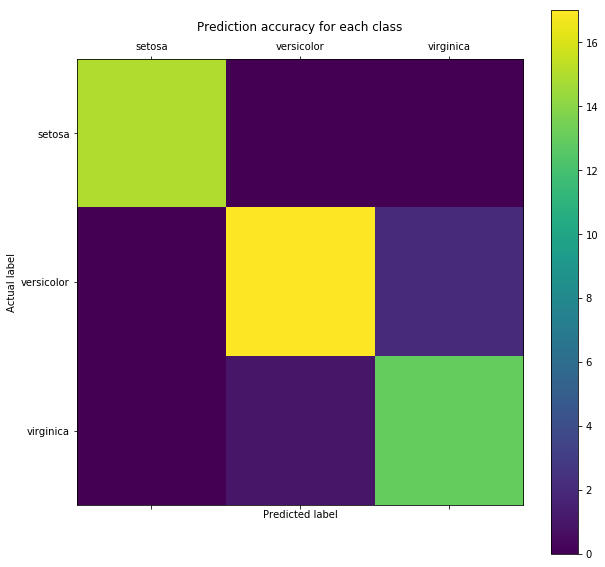

In [116]:
cm = confusion_matrix(pred_labels, true_labels)# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['setosa','versicolor','virginica'], 
                     columns = ['setosa','versicolor','virginica'])

fig, ax = plt.subplots(figsize = (10, 10))
ax.matshow(cm_df)
fig.colorbar(ax.matshow(cm_df))
ax.set_title("Prediction accuracy for each class")
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
ax.set_yticklabels(["", "setosa", "versicolor", "virginica"])
ax.set_xticklabels(["", "setosa", "versicolor", "virginica"])
plt.show()